In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
#from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score

In [2]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(72, (3, 3),  kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    #c1 = Dropout(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(144, (3, 3),  kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    #c2 = Dropout(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(288, (3, 3),  kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    #c3 = Dropout(0.2)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(576, (3, 3),  kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(576, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    #c4 = Dropout(0.2)(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #c5 = Dropout(0.3)(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)

    b1 = Conv2D(2304, (3, 3),  kernel_initializer='he_normal', padding='same')(p5) 
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(2304, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(b1) 
    #b1 = Dropout(0.3)(b1)
    
    #Expansive path 
    u7 = Conv2DTranspose(1152, (2, 2), strides=(2, 2), padding='same')(b1)
    u7 = concatenate([u7, c5])
    c6 = Conv2D(1152, (3, 3),  kernel_initializer='he_normal', padding='same')(u7)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(1152, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    #c6 = Dropout(0.2)(c6)
    
    u6 = Conv2DTranspose(576, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(576, (3, 3),  kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(576, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    #c6 = Dropout(0.2)(c6)
     
    u7 = Conv2DTranspose(288, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(288, (3, 3),  kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    #c7 = Dropout(0.2)(c7)
     
    u8 = Conv2DTranspose(144, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(144, (3, 3),  kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    #c8 = Dropout(0.1)(c8)
     
    u9 = Conv2DTranspose(72, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(72, (3, 3),  kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    #c9 = Dropout(0.1)(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [3]:
#image_dir = '/kaggle/input/glomeruli-hubmap-external-1024x1024/images_1024'
#mask_dir = '/kaggle/input/glomeruli-hubmap-external-1024x1024/masks_1024'
image_dir = 'images_1024'
mask_dir = 'masks_1024'

In [6]:
SIZE = 512
image_dataset = [] 
mask_dataset = []

imgNames = os.listdir(image_dir)
imgAddr = image_dir + '/'
maskAddr = mask_dir + '/'

#for i in range (len(imgNames)):
for i in range (200):
    try:
        #img = plt.imread(imgAddr + imgNames[i]) 
        #mask = plt.imread(maskAddr + imgNames[i])
        image = cv2.imread(imgAddr+imgNames[i], cv2.IMREAD_COLOR)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask = cv2.imread(maskAddr+imgNames[i], 0)
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_array = np.array(mask)
    except:
        continue
    
    if np.any(mask_array):
        image_dataset.append(np.array(image))
        mask_dataset.append(np.array(mask))

image_dataset = np.expand_dims(np.array(image_dataset),3)
image_dataset=np.squeeze(image_dataset)
#image_dataset = np.expand_dims(np.array(image_dataset),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3)
#X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.2, random_state=0)
#X_train = np.squeeze(X_train)

In [5]:
"""SIZE = 512
image_dataset = [] 
mask_dataset = []

imgNames = os.listdir(image_dir)
imgAddr = image_dir + '/'
maskAddr = mask_dir + '/'

for imgName in imgNames:
    try:
        image = cv2.imread(imgAddr + imgName, cv2.IMREAD_COLOR)  # Read RGB image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (SIZE, SIZE))
        
        mask = cv2.imread(maskAddr + imgName, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
        mask = cv2.resize(mask, (SIZE, SIZE))
    except Exception as e:
        print(f"Error processing image {imgName}: {str(e)}")
        continue
    
    if np.any(mask):
        image_dataset.append(image)
        mask_dataset.append(mask)

image_dataset = np.array(image_dataset)
image_dataset = np.expand_dims(normalize(image_dataset, axis=1), 3)  # Normalize and expand dimensions

mask_dataset = np.array(mask_dataset) / 255.0  # Normalize masks and expand dimensions

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=0)
"""

'SIZE = 512\nimage_dataset = [] \nmask_dataset = []\n\nimgNames = os.listdir(image_dir)\nimgAddr = image_dir + \'/\'\nmaskAddr = mask_dir + \'/\'\n\nfor imgName in imgNames:\n    try:\n        image = cv2.imread(imgAddr + imgName, cv2.IMREAD_COLOR)  # Read RGB image\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB\n        image = cv2.resize(image, (SIZE, SIZE))\n        \n        mask = cv2.imread(maskAddr + imgName, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask\n        mask = cv2.resize(mask, (SIZE, SIZE))\n    except Exception as e:\n        print(f"Error processing image {imgName}: {str(e)}")\n        continue\n    \n    if np.any(mask):\n        image_dataset.append(image)\n        mask_dataset.append(mask)\n\nimage_dataset = np.array(image_dataset)\nimage_dataset = np.expand_dims(normalize(image_dataset, axis=1), 3)  # Normalize and expand dimensions\n\nmask_dataset = np.array(mask_dataset) / 255.0  # Normalize masks and expand dimensions\n\nX_train, 

1
16


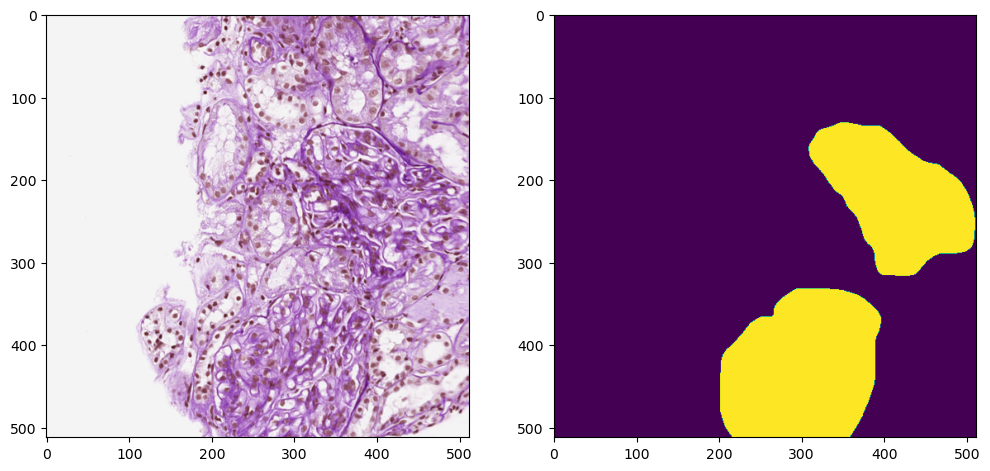

In [7]:


#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train)-1)
print(image_number)
print(len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE,3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)))
plt.show()

In [8]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS)




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 72)         2016      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 72)         288       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 72)         46728     ['batch_normalization[0

In [1]:
history = model.fit(X_train, y_train, batch_size = 8, verbose=1, epochs=10, validation_data=(X_test, y_test), shuffle=False)

#model.save('5layerUnet.hdf5')

NameError: name 'model' is not defined

In [ ]:
mask

2024-04-01 16:03:41.474552: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,72,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,72,512,512]{3,2,1,0}, f32[72,72,3,3]{3,2,1,0}, f32[72]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 16:03:41.716109: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.241676399s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[32,72,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,72,512,512]{3,2,1,0}, f32[72,72,3,3]{3,2,1,0}, f32[72]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is

1/2 ━━━━━━━━━━━━━━━━━━━━ 3:23 203s/step - accuracy: 0.9281 - loss: 0.0032

2024-04-01 16:08:30.417774: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[23,144,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,288,256,256]{3,2,1,0}, f32[144,288,3,3]{3,2,1,0}, f32[144]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-01 16:08:30.481031: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.06344209s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[23,144,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,288,256,256]{3,2,1,0}, f32[144,288,3,3]{3,2,1,0}, f32[144]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alp

2/2 ━━━━━━━━━━━━━━━━━━━━ 332s 128s/step - accuracy: 0.9239 - loss: 0.0034
Accuracy =  92.17911958694458 %


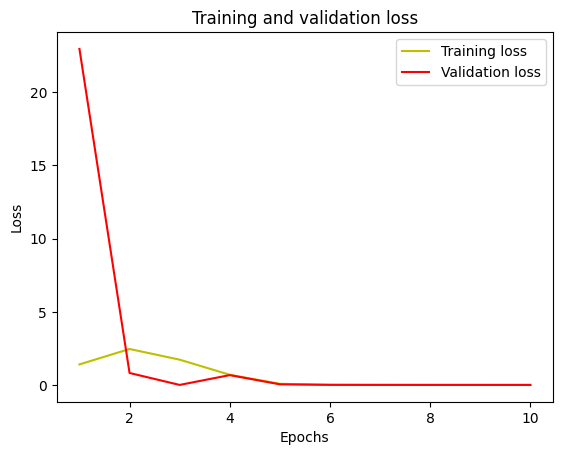

In [9]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

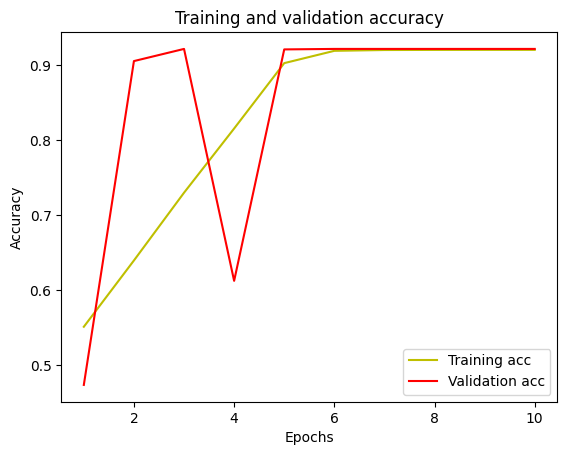

In [18]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [77]:
y_pred=model.predict(X_test)

intersection = np.logical_and(y_test, y_pred)
union = np.logical_or(y_test, y_pred)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)
#print(intersection.any())

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 
IoU socre is:  0.07820878462357954


In [86]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

In [87]:
prediction = (model.predict(test_img_input)[0,:,:,0])#.astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


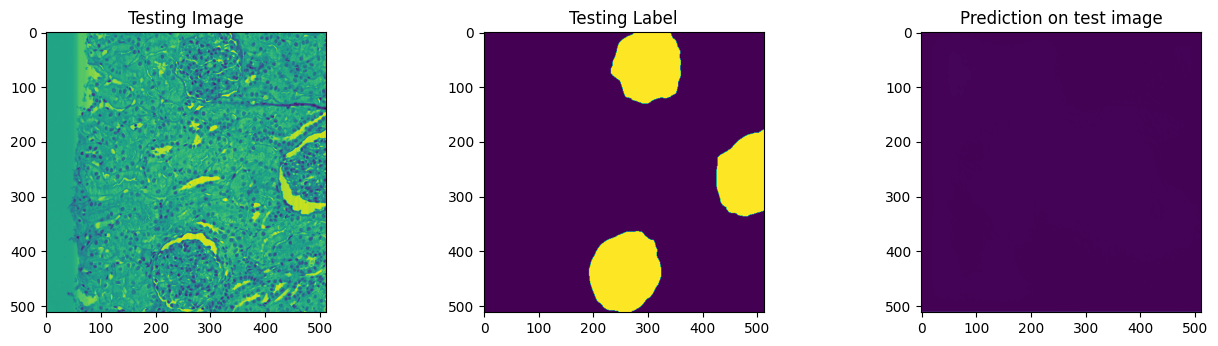

In [91]:


#test_img_other = cv2.imread('1bc.jpge',0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
#test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
#test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
#test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
"""plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')"""
plt.show()

In [41]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(ground_truth.flatten(), binary_predictions.flatten(), average='binary')


ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [46]:
threshold = 0
binary_predictions = np.where(prediction >= threshold, 1, 0)

[[[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[ True]
   [ True]
   [ True]
   ...
   [False]
   [False]
   [False]]

  [[ True]
   [ True]
   [ True]
   ...
   [False]
   [False]
   [False]]

  [[ True]
   [ True]
   [ True]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  ...

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]]


 [[[False]
   [False]
   [False]
   ...
   [False]
   [False]
   [False]]

  [[Fal